<a href="https://colab.research.google.com/github/Sciform/sciform-hwz-ai-in-controlling/blob/main/ts_07_forecasting_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with a CNN

## Setup

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

# Print Keras version
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.3.3


In [9]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

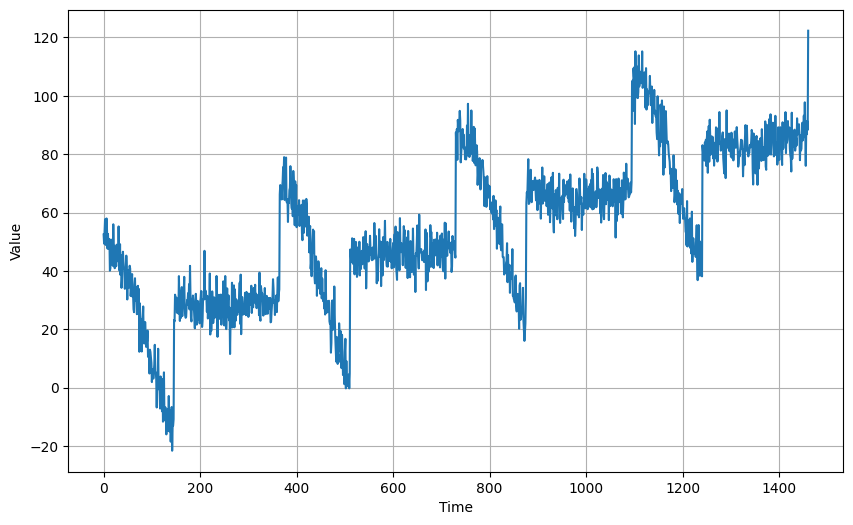

In [10]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Input(shape=[None, 1]),
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu"),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 23.2077 - mae: 23.7026 - learning_rate: 1.0000e-08
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 21.7809 - mae: 22.2757 - learning_rate: 1.1220e-08
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 21.7583 - mae: 22.2530 - learning_rate: 1.2589e-08
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 21.8198 - mae: 22.3146 - learning_rate: 1.4125e-08
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 21.8417 - mae: 22.3364 - learning_rate: 1.5849e-08
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 21.7529 - mae: 22.2481 - learning_rate: 1.7783e-08
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 21.5961 - mae: 22.0907 - learning_rate: 1.9953e-08
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 21.5413 - mae: 22.0361 - learning_rate: 2.2387e-08
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 21.1801 - mae: 21.6745 - learning_rate: 2.5119e-08
Epoch 10/100
8/8 ━━

(1e-08, 0.0001, 0.0, 30.0)

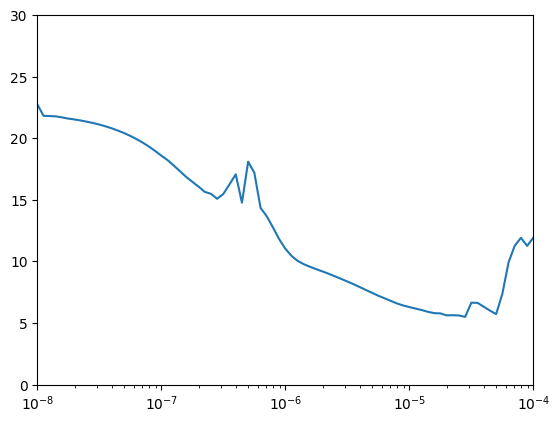

In [13]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Input(shape=[None, 1]),
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu"),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.keras", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 54.9557 - mae: 55.4544 - val_loss: 34.6525 - val_mae: 35.1511
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 21.1464 - mae: 21.6408 - val_loss: 20.4914 - val_mae: 20.9851
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 12.4381 - mae: 12.9290 - val_loss: 15.1481 - val_mae: 15.6401
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 10.5669 - mae: 11.0565 - val_loss: 13.5018 - val_mae: 13.9927
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 8.6003 - mae: 9.0865 - val_loss: 14.8280 - val_mae: 15.3204
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 7.8151 - mae: 8.2980 - val_loss: 13.1409 - val_mae: 13.6336
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 6.9934 - mae: 7.4753 - val_loss: 10.6226 - val_mae: 11.1106
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 6.9157 - mae: 7.3956 - val_loss: 10.5037 - val_mae: 10.9918
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/st

In [15]:
model = keras.models.load_model("my_checkpoint.keras", safe_mode=False)

In [16]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


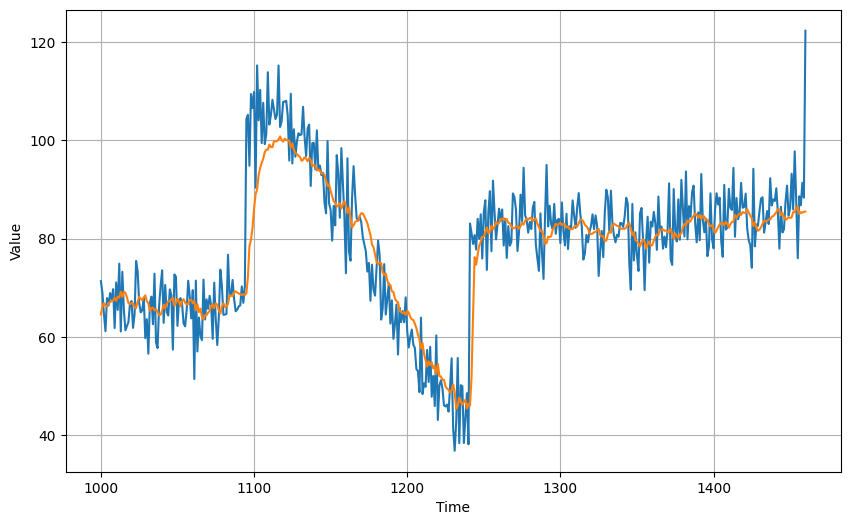

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [18]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.146407

## Fully Convolutional Forecasting

Convolutional Neural Networks are a special architecture of Deep Learning Models. Here we look specifically at the so-called wave-net architecture, which is particularly suitable fore time series forecasting. Except the new Neural Network architecture (and a slightly more suitable optimizer - Adam instead of SGD), everything is the same as in the "simple" approach!

### Learning Rate Scheduler

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64

# create data set
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

### DEEP NEURAL NETWERK ARCHITECTURE ###########################################
# create wave net CNN architecture
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[None, 1]))
# add a number of 1D Convolutional Layer with varying dilation to the network
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
# add a final layer with 1 filter   
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
################################################################################

# setup learning rate scheduler
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

# here we do not use Stochastic Gradient Descent but the Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# setup model with loss function, optimizer and mean absolute error metr
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# train the model for different learning rate schedulers
lr_model = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 42.5887 - mae: 43.0875 - learning_rate: 1.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 42.0613 - mae: 42.5601 - learning_rate: 1.0798e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 41.2878 - mae: 41.7866 - learning_rate: 1.1659e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 42.1035 - mae: 42.6026 - learning_rate: 1.2589e-04
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 41.7394 - mae: 42.2385 - learning_rate: 1.3594e-04
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 40.9148 - mae: 41.4140 - learning_rate: 1.4678e-04
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 40.1183 - mae: 40.6173 - learning_rate: 1.5849e-04
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 38.1425 - mae: 38.6411 - learning_rate: 1.7113e-04
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 37.5789 - mae: 38.0774 - learning_rate: 1.8478e-04
Epoch 10/100
8/8 ━━

### Determine optimal learning rate

(0.0001, 0.1, 0.0, 30.0)

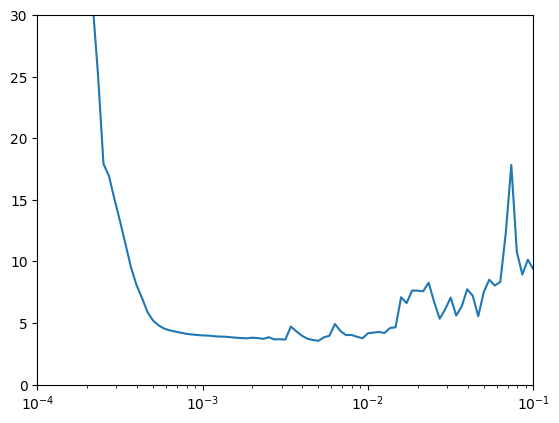

In [20]:
plt.semilogx(lr_model.history["learning_rate"], lr_model.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

# create Wave Net architecture
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# this saves the model to a file and we can load it later from file for our forecast without reruning the training
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.keras", save_best_only=True)

# training stops if now significant improvement after a "patience" of 50 epochs
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 39.4629 - mae: 39.9617 - val_loss: 32.2710 - val_mae: 32.7675
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 18.7233 - mae: 19.2177 - val_loss: 26.3927 - val_mae: 26.8900
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 12.9983 - mae: 13.4898 - val_loss: 12.4499 - val_mae: 12.9413
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 7.4828 - mae: 7.9674 - val_loss: 10.2153 - val_mae: 10.7057
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.7378 - mae: 6.2196 - val_loss: 5.6398 - val_mae: 6.1217
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 4.7545 - mae: 5.2332 - val_loss: 5.2127 - val_mae: 5.6923
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.3793 - mae: 4.8581 - val_loss: 4.5264 - val_mae: 5.0027
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.1827 - mae: 4.6593 - val_loss: 4.4381 - val_mae: 4.9144
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss:

In [22]:
model = keras.models.load_model("my_checkpoint.keras", safe_mode=False)

In [23]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


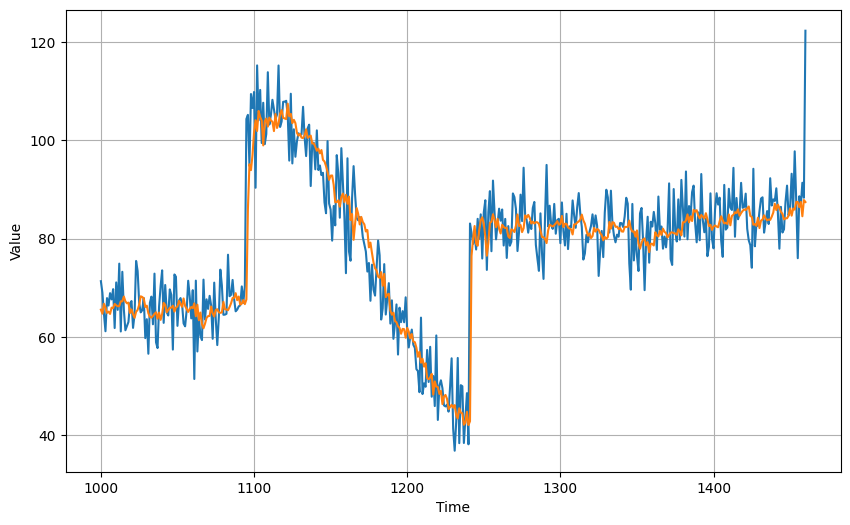

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [25]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.4815717

In [26]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Source: https://github.com/tensorflow/examples